In [1]:
import sys
sys.path.append('..')
import os
import shutil
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle

from multiprocess import Pool
from program.helper import *
from program.mlp_optimization import *
from program.utility import *

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import KFold

In [4]:
with open('../program/label_translator.pkl', 'rb') as pkl_file:
    label_translator = pickle.load(pkl_file)

## Pre-Processing

In [2]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((227, 227)), 
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
train_data = ImageFolder("../data/train", transform=transform_images)
test_data = ImageFolder("../data/test", transform=transform_images)

In [5]:
dataloader_train = DataLoader(train_data, batch_size=150, shuffle=True, 
                              num_workers=24, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size=150, shuffle=True, 
                             num_workers=24, pin_memory=True)

# S5: Anwendung Batchnorm

Nutzung von Batchnorm ohne Regularisierung und mit Stochastic Gradient Descent.


In [6]:
from networks import FlatAlexNetBN, FlatAlexNetOpt

In [7]:
batch_norm_model = FlatAlexNetBN(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(batch_norm_model.parameters(),  lr=.008, momentum=.95)
dtype = torch.float32
print_total_params(batch_norm_model)

Trainable Parameters: 72790133


In [19]:
metrics = train_network_kfold(model=batch_norm_model, train_data=train_data, test_data=test_data,
                              criterion=criterion, optimizer=optimizer, n_epochs=40, k_folds=10, batch_sizes=150)

==================== Fold 0 ====================


Epoch: 40/40 // Running Loss: 18.784 // Accuracy: 0.625 : 100%|██████████| 6800/6800 [13:35<00:00,  8.34it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]

==================== Fold 1 ====================



Epoch: 40/40 // Running Loss: 8.29 // Accuracy: 0.716 : 100%|██████████| 6800/6800 [13:46<00:00,  8.22it/s]   


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  6.08it/s]

==================== Fold 2 ====================



Epoch: 40/40 // Running Loss: 4.941 // Accuracy: 0.744 : 100%|██████████| 6800/6800 [13:25<00:00,  8.45it/s]  


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  6.19it/s]

==================== Fold 3 ====================



Epoch: 40/40 // Running Loss: 2.919 // Accuracy: 0.725 : 100%|██████████| 6800/6800 [13:17<00:00,  8.52it/s]  


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.54it/s]


==================== Fold 4 ====================


Epoch: 40/40 // Running Loss: 5.517 // Accuracy: 0.752 : 100%|██████████| 6800/6800 [13:26<00:00,  8.43it/s]  


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.88it/s]

==================== Fold 5 ====================



Epoch: 40/40 // Running Loss: 1.304 // Accuracy: 0.772 : 100%|██████████| 6800/6800 [13:21<00:00,  8.49it/s]  


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.96it/s]


==================== Fold 6 ====================


Epoch: 40/40 // Running Loss: 0.641 // Accuracy: 0.784 : 100%|██████████| 6800/6800 [13:23<00:00,  8.47it/s]  


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  6.08it/s]

==================== Fold 7 ====================



Epoch: 40/40 // Running Loss: 1.012 // Accuracy: 0.801 : 100%|██████████| 6800/6800 [13:22<00:00,  8.48it/s]  


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  6.02it/s]

==================== Fold 8 ====================



Epoch: 40/40 // Running Loss: 0.26 // Accuracy: 0.789 : 100%|██████████| 6800/6800 [13:23<00:00,  8.47it/s]   


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  6.09it/s]

==================== Fold 9 ====================



Epoch: 40/40 // Running Loss: 0.215 // Accuracy: 0.81 : 100%|██████████| 6800/6800 [13:25<00:00,  8.44it/s]   


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.93it/s]


In [20]:
save_file = False

if save_file:
    with open('./saved/batchnorm_metrics.pkl', 'wb') as pkl_file:
        pickle.dump(metrics, pkl_file)

In [8]:
opt_model = FlatAlexNetOpt(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(opt_model.parameters(),  lr=.008, momentum=.95)
dtype = torch.float32
print_total_params(opt_model)

Trainable Parameters: 72756991


In [24]:
metrics_opt = train_network_kfold(model=opt_model, train_data=train_data, test_data=test_data,
                                  criterion=criterion, optimizer=optimizer, n_epochs=40, k_folds=10, 
                                  batch_sizes=150)

==================== Fold 0 ====================


Epoch: 40/40 // Running Loss: 18.737 // Accuracy: 0.562 : 100%|██████████| 6800/6800 [13:18<00:00,  8.51it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]

==================== Fold 1 ====================



Epoch: 40/40 // Running Loss: 18.192 // Accuracy: 0.552 : 100%|██████████| 6800/6800 [13:23<00:00,  8.47it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.83it/s]

==================== Fold 2 ====================



Epoch: 40/40 // Running Loss: 15.225 // Accuracy: 0.559 : 100%|██████████| 6800/6800 [13:27<00:00,  8.42it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.76it/s]

==================== Fold 3 ====================



Epoch: 40/40 // Running Loss: 20.078 // Accuracy: 0.546 : 100%|██████████| 6800/6800 [13:25<00:00,  8.44it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.85it/s]

==================== Fold 4 ====================



Epoch: 40/40 // Running Loss: 16.455 // Accuracy: 0.549 : 100%|██████████| 6800/6800 [13:26<00:00,  8.43it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.84it/s]

==================== Fold 5 ====================



Epoch: 40/40 // Running Loss: 20.522 // Accuracy: 0.555 : 100%|██████████| 6800/6800 [13:29<00:00,  8.40it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.82it/s]

==================== Fold 6 ====================



Epoch: 40/40 // Running Loss: 19.323 // Accuracy: 0.553 : 100%|██████████| 6800/6800 [13:28<00:00,  8.41it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]

==================== Fold 7 ====================



Epoch: 40/40 // Running Loss: 15.384 // Accuracy: 0.558 : 100%|██████████| 6800/6800 [13:30<00:00,  8.39it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


==================== Fold 8 ====================


Epoch: 40/40 // Running Loss: 18.035 // Accuracy: 0.558 : 100%|██████████| 6800/6800 [13:26<00:00,  8.43it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  6.00it/s]

==================== Fold 9 ====================



Epoch: 40/40 // Running Loss: 19.854 // Accuracy: 0.558 : 100%|██████████| 6800/6800 [13:37<00:00,  8.32it/s] 


Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.84it/s]


In [25]:
if save_file:
    with open('./saved/batchnorm_metrics_opt.pkl', 'wb') as pkl_file:
        pickle.dump(metrics_opt, pkl_file)

### Analyze Results

In [146]:
with open('./saved/batchnorm_metrics.pkl', 'rb') as pkl_file:
    metrics_batch = pickle.load(pkl_file)

In [147]:
with open('./saved/batchnorm_metrics_opt.pkl', 'rb') as pkl_file:
    metrics_opt = pickle.load(pkl_file)

In [148]:
losses_batch = pd.DataFrame.from_dict(metrics_batch['losses'])
losses_opt = pd.DataFrame.from_dict(metrics_opt['losses'])
losses_batch.head(2)

,0,1,2,3,4,5,6,7,8,9
0,3.419793,3.362413,3.327786,3.384193,3.380545,3.350433,3.369921,3.337568,3.367136,3.379411
1,3.344729,3.379970,3.347100,3.329983,3.397920,3.349971,3.322893,3.385277,3.375402,3.409222


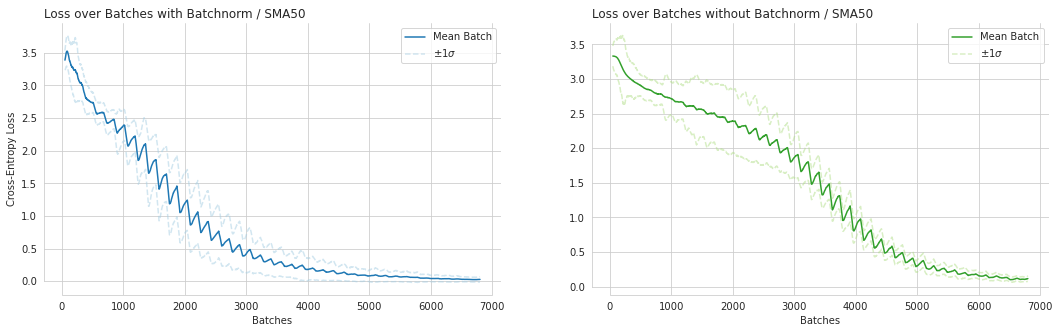

In [150]:
colors = sns.color_palette('Paired', 4)

fig = plt.subplots(figsize=(18, 5))

sma = 50

plt.subplot(1,2,1)
column_selection = list(losses_batch.columns)
mean_loss_folds = losses_batch[column_selection].mean(axis=1)
mean_loss_folds = mean_loss_folds.rolling(sma).mean()
std_loss_folds = losses_batch[column_selection].std(axis=1)
std_loss_folds = std_loss_folds.rolling(sma).mean()

p = sns.lineplot(x=mean_loss_folds.index, y=mean_loss_folds, label='Mean Batch', color=colors[1])
p = sns.lineplot(x=mean_loss_folds.index, y=mean_loss_folds + std_loss_folds, 
                 label=r'$\pm1\sigma$', color=colors[0], linestyle='--', alpha=.5)
p = sns.lineplot(x=mean_loss_folds.index, y=mean_loss_folds - std_loss_folds, 
                 color=colors[0], linestyle='--', alpha=.5)
p.set_title(f'Loss over Batches with Batchnorm / SMA{50}',loc='left')
p.set_xlabel('Batches')
p.set_ylabel('Cross-Entropy Loss')
sns.despine(trim=True)

plt.subplot(1,2,2)
column_selection = list(losses_opt.columns)
mean_loss_folds = losses_opt[column_selection].mean(axis=1)
mean_loss_folds = mean_loss_folds.rolling(sma).mean()
std_loss_folds = losses_batch[column_selection].std(axis=1)
std_loss_folds = std_loss_folds.rolling(sma).mean()

p = sns.lineplot(x=mean_loss_folds.index, y=mean_loss_folds, label='Mean Batch', 
                 color=colors[3])
p = sns.lineplot(x=mean_loss_folds.index, y=mean_loss_folds + std_loss_folds, 
                 label=r'$\pm1\sigma$', color=colors[2], linestyle='--', alpha=.5)
p = sns.lineplot(x=mean_loss_folds.index, y=mean_loss_folds - std_loss_folds,
                 color=colors[2], linestyle='--', alpha=.5)
p.set_title(f'Loss over Batches without Batchnorm / SMA{50}',loc='left')
p.set_xlabel('Batches')
#p.set_ylabel('Cross-Entropy Loss')
sns.despine(trim=True)

plt.show()

-----------

In [135]:
nobatch = pd.DataFrame.from_records(metrics_opt['metrics']).T
tmp = nobatch.explode('accuracy')['accuracy']
nobatch = nobatch.explode('precision')['precision']
nobatch = pd.concat([tmp, nobatch], axis=1, ignore_index=True)
nobatch.columns = ['Accuracy', 'Precision']
nobatch = nobatch.reset_index(drop=True)
nobatch['set'] = ['train' if i%2==0 else 'test' for i in range(nobatch.shape[0])]
nobatch['type'] = 'no batch'
nobatch.head(2)

,Accuracy,Precision,set,type
0,0.975177,0.975736,train,no batch
1,0.232212,0.234917,test,no batch


In [136]:
batch = pd.DataFrame.from_records(metrics_batch['metrics']).T
tmp = batch.explode('accuracy')['accuracy']
batch = batch.explode('precision')['precision']
batch = pd.concat([tmp, batch], axis=1, ignore_index=True)
batch.columns = ['Accuracy', 'Precision']
batch = batch.reset_index(drop=True)
batch['set'] = ['train' if i%2==0 else 'test' for i in range(batch.shape[0])]
batch['type'] = 'batch'
batch.head(2)

,Accuracy,Precision,set,type
0,0.980488,0.980811,train,batch
1,0.201416,0.202579,test,batch


In [137]:
df = pd.concat([batch, nobatch], axis=0)
df.head(2)

,Accuracy,Precision,set,type
0,0.980488,0.980811,train,batch
1,0.201416,0.202579,test,batch


In [138]:
df = df.reset_index(drop=True)
df = df.melt(id_vars=['set', 'type'])
df.columns = ['set', 'type','metric', 'score']
df.head(2)

,set,type,metric,score
0,train,batch,Accuracy,0.980488
1,test,batch,Accuracy,0.201416


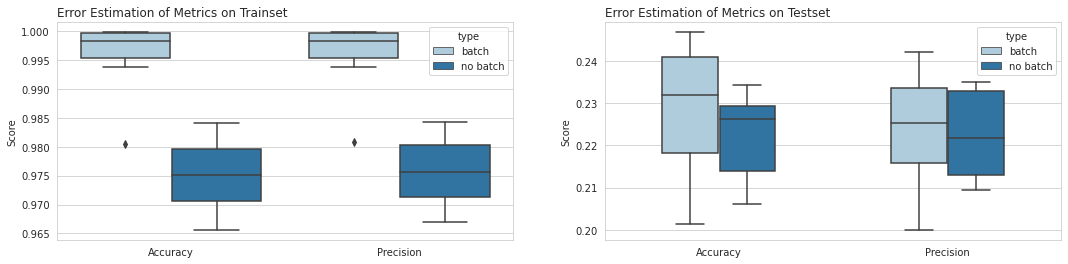

In [142]:
fig = plt.subplots(figsize=(18, 4))

sns.set_palette('Paired', 4)
sns.set_style('whitegrid')
plt.subplot(1,2,1)
tmp = df[df['set'].str.contains('train')]
p = sns.boxplot(data=tmp, x='metric', y='score', hue='type', width=.8)
p.set_title('Error Estimation of Metrics on Trainset', loc='left')
p.set_xlabel('')
p.set_ylabel('Score')

plt.subplot(1,2,2)
tmp = df[df['set'].str.contains('test')]
p = sns.boxplot(data=tmp, x='metric', y='score' , hue='type',width=.5)
p.set_title('Error Estimation of Metrics on Testset', loc='left')
#p.set_xticklabels(['Precision', 'Accuracy'])
p.set_xlabel('')
p.set_ylabel('Score')

plt.show()